# Effects of data smoothing on parameter estimates



In [1]:
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

from numpyro.distributions.transforms import AffineTransform, ExpTransform, ComposeTransform, IdentityTransform

npyro.enable_validation(True)
sns.set(style='white', context='notebook', palette='muted')

In [2]:
def fun_I(x, aX, aI, g0):
    par1 = (g0 + aX)/(g0 - aI)
    par2 = (1 + aX)/aI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * aI/g0) - 1)

def static(N, data, obs=None):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    f = npyro.sample('f', dist.Exponential(1.))
    normalisation_factor = npyro.deterministic('nf', f * float(N))
    
    X_data = data['X']
    I_data = data['I']
    
    a_X = npyro.sample('a_X', dist.Gamma(10., 1.))
    a_I = npyro.sample('a_I', dist.Gamma(1000., 2.))
    
    g0 = npyro.sample('g0', dist.Gamma(3., 2.))
    
    I_pred = normalisation_factor * fun_I(X_data/normalisation_factor, a_X, a_I, g0)
    
    I_pred = npyro.deterministic('I', np.where(I_pred > 0, I_pred, 1.))
        
    # measurement errors
    scale_I = npyro.sample("scale_I", dist.InverseGamma(2., 1.))
    
    with npyro.plate('obs', X_data.shape[0]):
        o_i = dist.Normal(0., 1.)
        o_i_1 = dist.TransformedDistribution(o_i, AffineTransform(np.log(I_pred), np.sqrt(scale_I)))
        npyro.sample("I_o", dist.TransformedDistribution(o_i_1, ExpTransform()), obs=obs)

In [3]:
# load information about the population in different regions
df_N = pd.read_csv('region_population.csv', index_col=0)

#########################                  
# Note that the region of Trentino-Alto Adige covers, regions of P.A. Bolzano and P.A. Trento which
# are included in the italy's. Hence we will combine them in one in the table bellow. 
#########################

# Load national data in Italy
df_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

# Load and format region specific data.
df_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-regioni/dpc-covid19-ita-regioni.csv')

df_regional = df_regional.set_index('data')

# Merge data for Trento and Bolzano into Trentino-Alto Adige
loc_bolz = df_regional.denominazione_regione == 'P.A. Bolzano'
loc_tren = df_regional.denominazione_regione == 'P.A. Trento'

df_ta = df_regional.loc[loc_bolz, 'totale_positivi':] + \
        df_regional.loc[loc_tren, 'totale_positivi':]

df_ta['denominazione_regione'] = 'Trentino-Alto Adige'

df_regional = df_regional.append(df_ta).reset_index()
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Bolzano'].index)
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Trento'].index)

In [4]:
df_national.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                      inplace=True)

df_national['dD'] = df_national['D'].diff()
df_national.loc[0, 'dD'] = df_national.loc[0, 'D']

df_regional.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests', 
                            'denominazione_regione': 'region',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                     inplace=True)


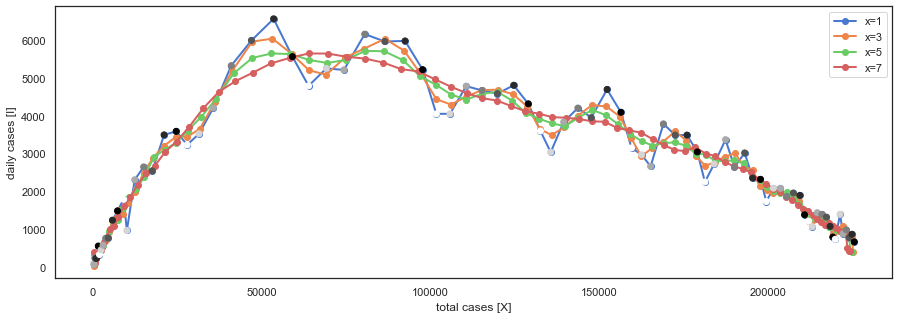

In [5]:
# plot data smoothed with x-days moving average

days = pd.to_datetime(df_national.date, infer_datetime_format=True).dt.dayofweek

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in [1, 3, 5, 7]:
    X = df_national.X.rolling(window=x, min_periods=1, center=True).mean()
    I = np.diff(np.concatenate([np.zeros(1), X.values], -1), axis=-1)
    axes.plot(X, I, 'o-', label='x={}'.format(x), lw=2)

axes.scatter(df_national.X.values, df_national.I.values, c=days.values/6., cmap='gray_r', zorder=10)

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend();

fig.savefig('smoothing.png', dpi=300)

In [6]:
# fitting the static model
num_warmup = 1000
num_samples = 1000

N = df_N.Population.sum()
samples = {}
rng_key = random.PRNGKey(2441245)
for x in [1, 3, 5, 7]:
    I = np.array(df_national.I.rolling(window=x, center=True).mean().values)
    X = np.array(df_national.X.rolling(window=x, center=True).mean().values)
    if x > 1:
        l = (x - 1) // 2
        I = I[l:-l]
        X = X[l:-l]
    
    data = {'X': np.array(X),
            'I': np.array(I)}
    
    obs = np.where(np.nan_to_num(I) > 0, I, 1.)

    nuts = NUTS(static, dense_mass=True, target_accept_prob=.9)
    mcmc = MCMC(nuts, num_warmup, num_samples)
    mcmc.run(rng_key, N=N, data=data, obs=obs)
    samples[x] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:09<00:00, 202.00it/s, 7 steps of size 3.15e-01. acc. prob=0.94] 


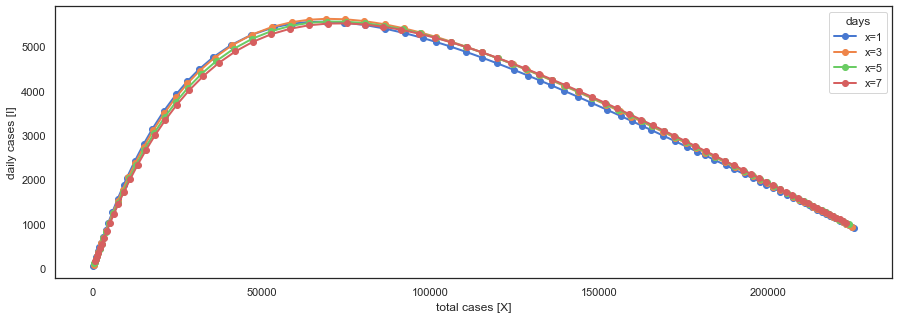

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in samples:
    X = df_national.X.rolling(window=x, center=True).mean().values
    if x > 1:
        l = (x-1) // 2
        X =X[l:-l]
    
    axes.plot(X, samples[x]['I'].mean(0), 'o-', label='x={}'.format(x), lw=2)

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend(title='days');

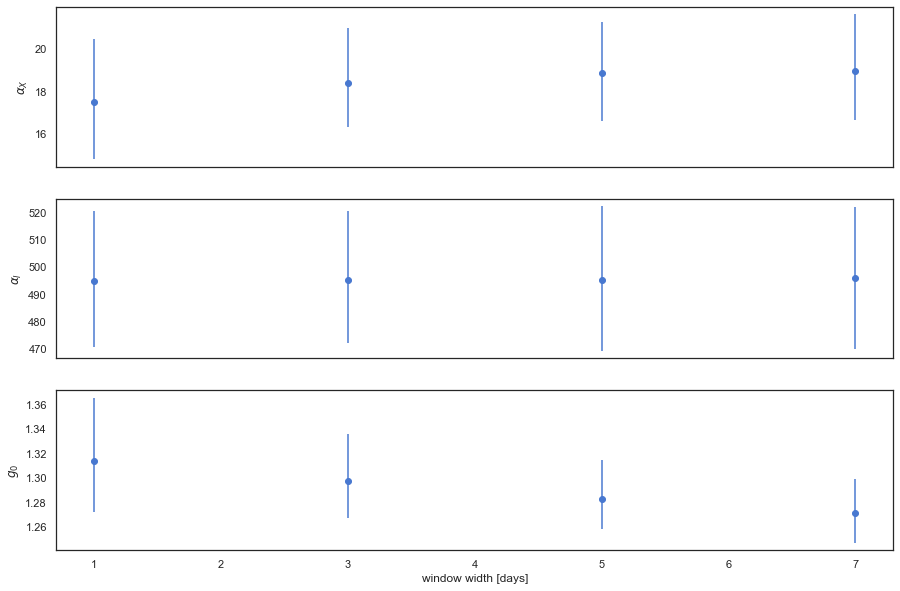

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for x in samples:
    a_x = np.percentile(samples[x]['a_X'], [5, 50, 95])
    yerr = np.array([a_x[1] - a_x[0], a_x[-1] - a_x[1]])[:, None]
    axes[0].errorbar(x, a_x[1], yerr=yerr, marker='o', color='b')
    axes[0].set_ylabel(r'$\alpha_X$')
    
    a_i = np.percentile(samples[x]['a_I'], [5, 50, 95])
    yerr = np.array([a_i[1] - a_i[0], a_i[-1] - a_i[1]])[:, None]
    axes[1].errorbar(x, a_i[1], yerr=yerr, marker='o', color='b')
    axes[1].set_ylabel(r'$\alpha_I$')
    
    g = np.percentile(samples[x]['g0'], [5, 50, 95])
    yerr = np.array([g[1] - g[0], g[-1] - g[1]])[:, None]
    axes[2].errorbar(x, g[1], yerr=yerr, marker='o', color='b')
    axes[2].set_ylabel(r'$g_0$')
    
axes[-1].set_xlabel('window width [days]');